In [11]:
import time
from pathlib import Path
from datetime import datetime

import torch
import monai
import pandas as pd
import torchio as tio
import matplotlib.pyplot as plt
import seaborn as sns

from train import get_net
from data import MedicalDecathlonDataModule

sns.set()
plt.rcParams['figure.figsize'] = 12, 8
monai.utils.set_determinism()

print('Last run on', time.ctime())

%load_ext tensorboard

Last run on Sun Apr  2 20:58:02 2023


# Visualize results of the Hippocampus segmentation model

Mostly copied from the torchio tutorial, but adapted for showing results of the `train.py` script.

Here we assume we've already trained a model using `train.py`

## Select model and data

In [13]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 16700), started 0:30:11 ago. (Use '!kill 16700' to kill it.)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_net()
model.to(device)
data = MedicalDecathlonDataModule(task='Task04_Hippocampus', 
                                    google_id='1RzPB1_bqzQhlWvU-YGvZzhx2omcDh38C',
                                    batch_size=16,
                                    train_val_ratio=0.8)
print('Training:  ', len(data.train_set))
print('Validation: ', len(data.val_set))
print('Test:      ', len(data.test_set))

Training:   208
Validation:  52
Test:       130


In [15]:
# show runs we can select from
runs_dir = Path('runs')
for run_dir in sorted(runs_dir.iterdir()):
    print(f"{run_dir=}")

run_dir=WindowsPath('runs/hippocampus_01')
run_dir=WindowsPath('runs/hippocampus_02')


In [16]:
# select run
# comment out to select latest run
#run_dir = Path('runs/hippocampus_02')
print(f"{run_dir=}")

run_dir=WindowsPath('runs/hippocampus_02')


In [17]:
# show model checkpoints in run
for checkpoint_path in sorted(run_dir.glob("*.ckpt")):
    print(f"{checkpoint_path=}")

checkpoint_path=WindowsPath('runs/hippocampus_02/model_step00075.ckpt')


In [18]:
# select checkpoint
# comment out to use the last checkpoint
#checkpoint_path = run_dir.joinpath('model_step195.ckpt')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])



<All keys matched successfully>

## Plot validation results

We can perform a quantitative evaluation of our model performance on the validation set. Let's use our trained model to segment the hippocampus on all the images in the validation set and use MONAI to compute the [Dice score](https://docs.monai.io/en/latest/metrics.html) for each label of each case.

In [19]:
all_dices = []
get_dice = monai.metrics.DiceMetric(include_background=False, reduction='none')
with torch.no_grad():
    for batch in data.val_dataloader():
        inputs = batch['image'][tio.DATA]
        targets = batch['label'][tio.DATA]
        
        logits = model(inputs.to(device))
        labels = logits.argmax(dim=1)
        labels_one_hot = torch.nn.functional.one_hot(labels).permute(0, 4, 1, 2, 3)
        dices = get_dice(labels_one_hot.to(device), targets.to(device))
        all_dices.append(dices.cpu())
all_dices = torch.cat(all_dices)

Now that all Dice scores have been computed, we can use [Pandas](https://pandas.pydata.org/) and [Seaborn](https://seaborn.pydata.org/) to plot our results.

C:\Users\Roel\anaconda3\envs\icm\lib\site-packages\numpy\lib\arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


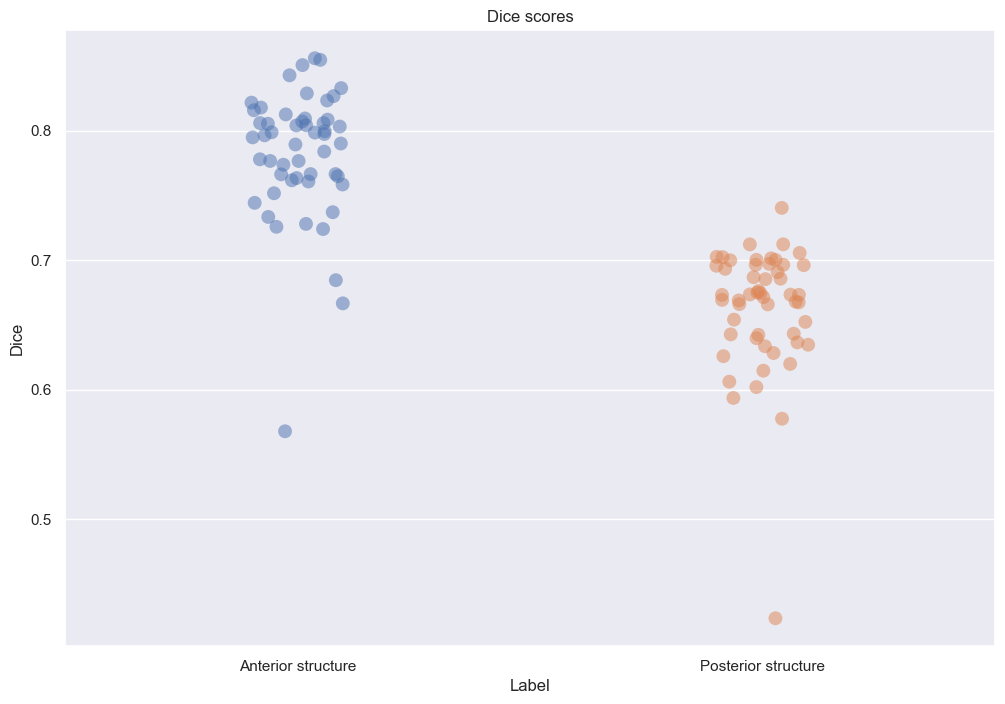

In [20]:
records = []
for ant, post in all_dices:
    records.append({'Dice': ant, 'Label': 'Anterior structure'})
    records.append({'Dice': post, 'Label': 'Posterior structure'})
df = pd.DataFrame.from_records(records)
ax = sns.stripplot(x='Label', y='Dice', data=df, size=10, alpha=0.5)
ax.set_title('Dice scores');

Not bad for a little tutorial! But it would be nice to actually _look_ at some results.


## Test

Let's see if the model also performs well on the test set. We will segment one batch and use TorchIO to plot the results.

In [21]:
with torch.no_grad():
    for batch in data.test_dataloader():
        inputs = batch['image'][tio.DATA].to(device)
        labels = model(inputs).argmax(dim=1, keepdim=True).cpu()
        for i in range(len(inputs)):
            break
        break   
batch_subjects = tio.utils.get_subjects_from_batch(batch)
tio.utils.add_images_from_batch(batch_subjects, labels, tio.LabelMap)

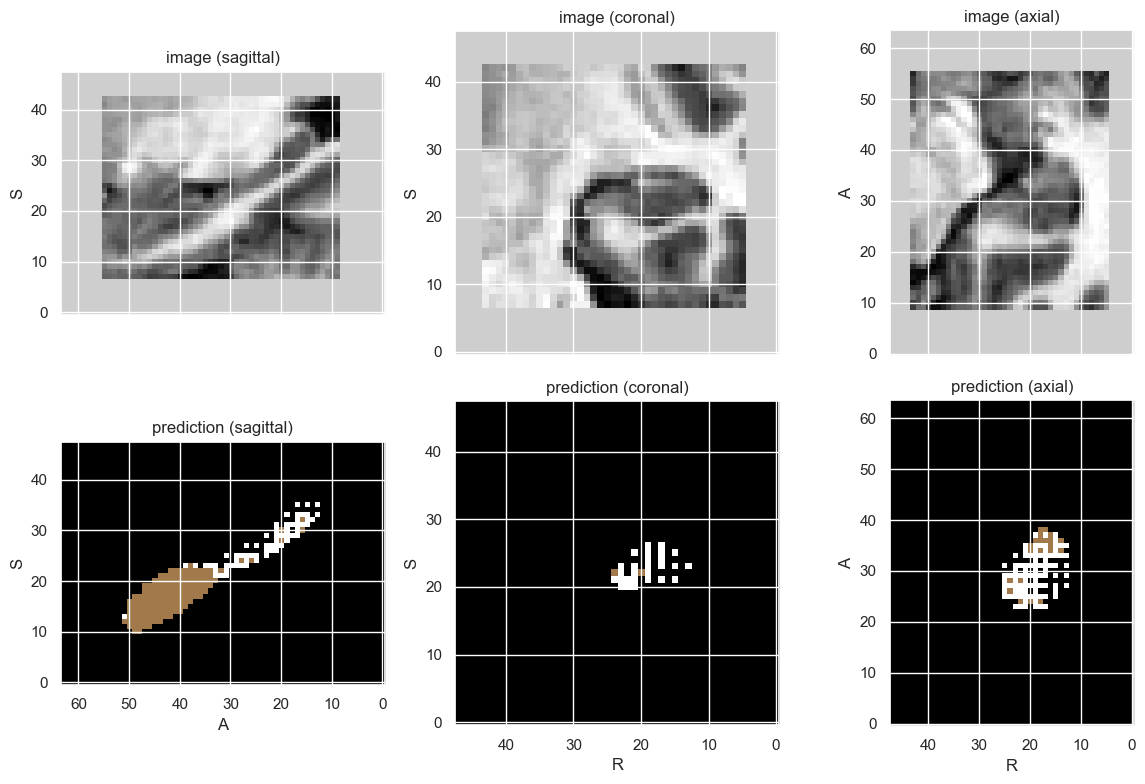

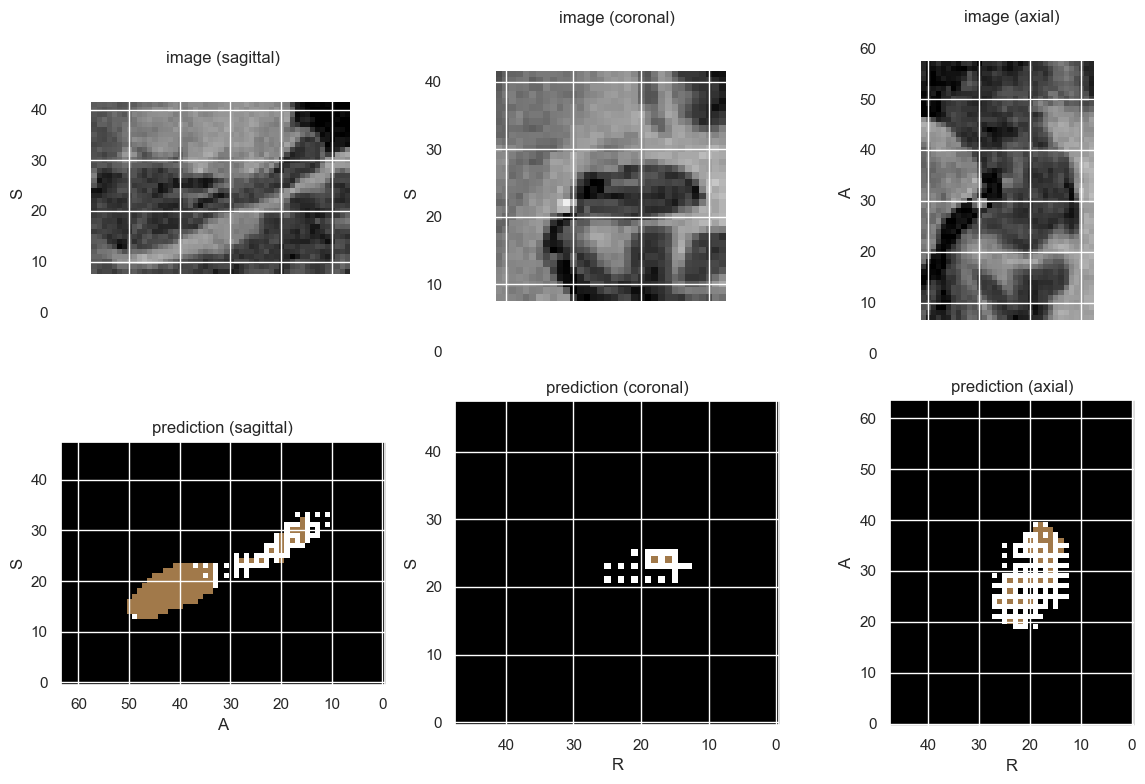

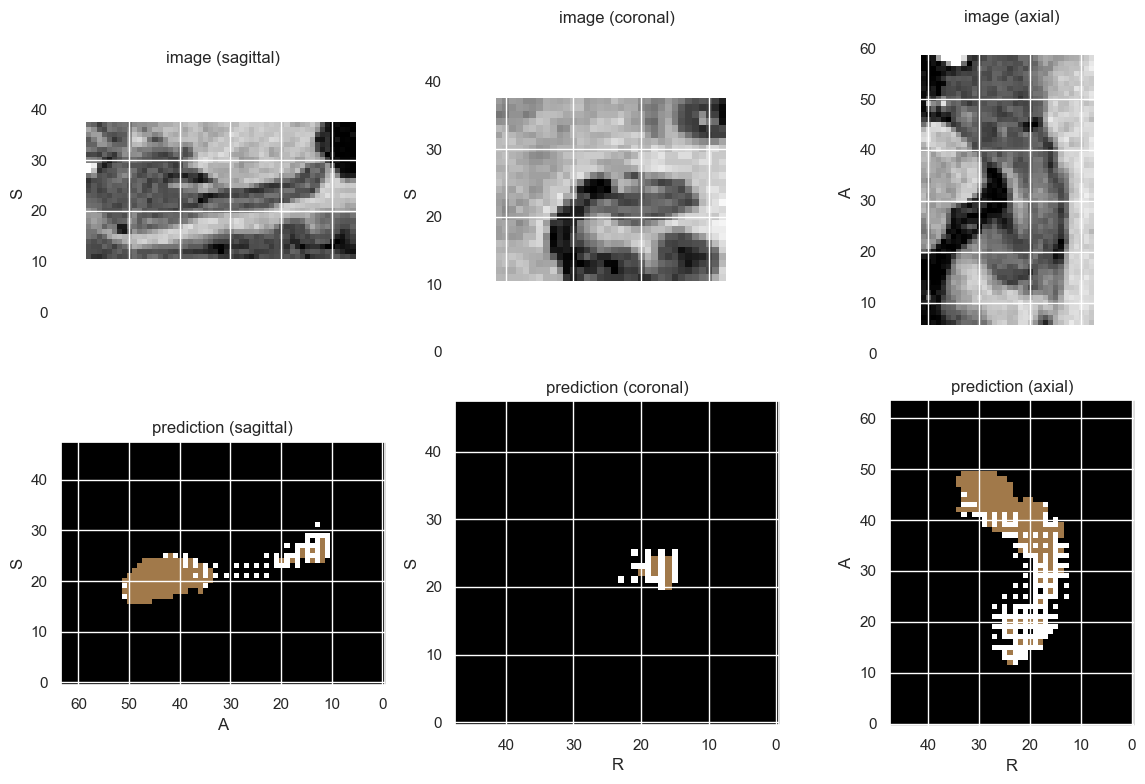

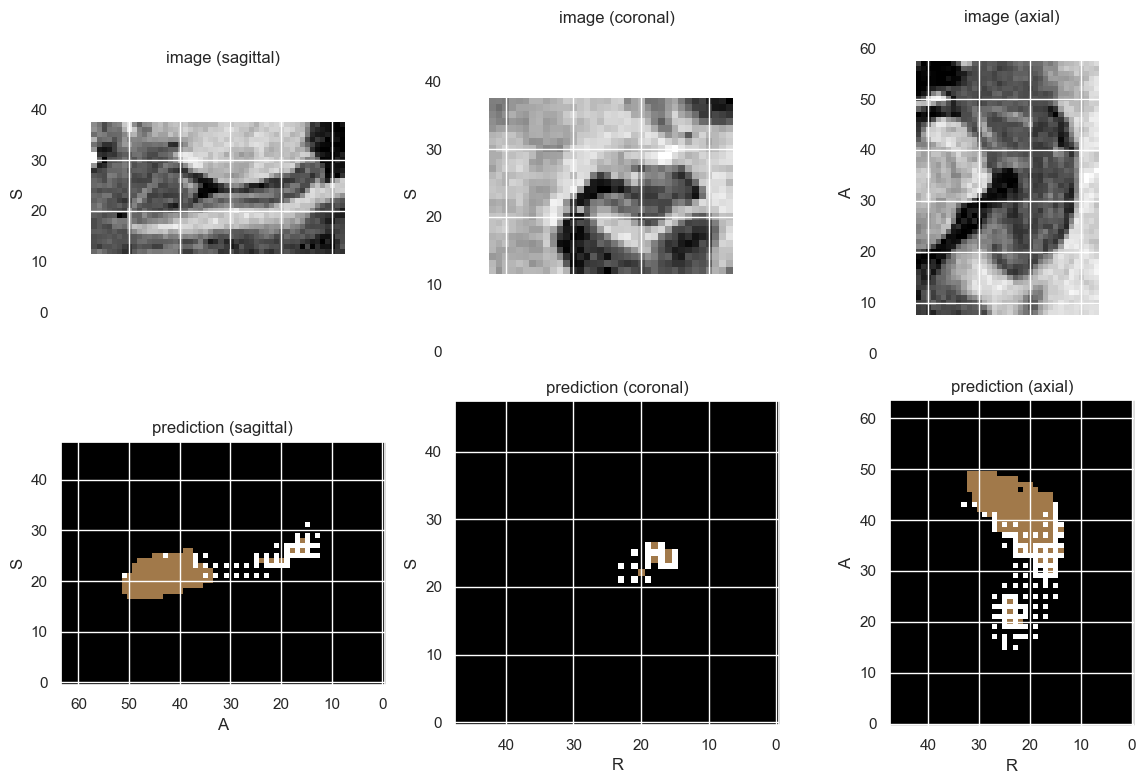

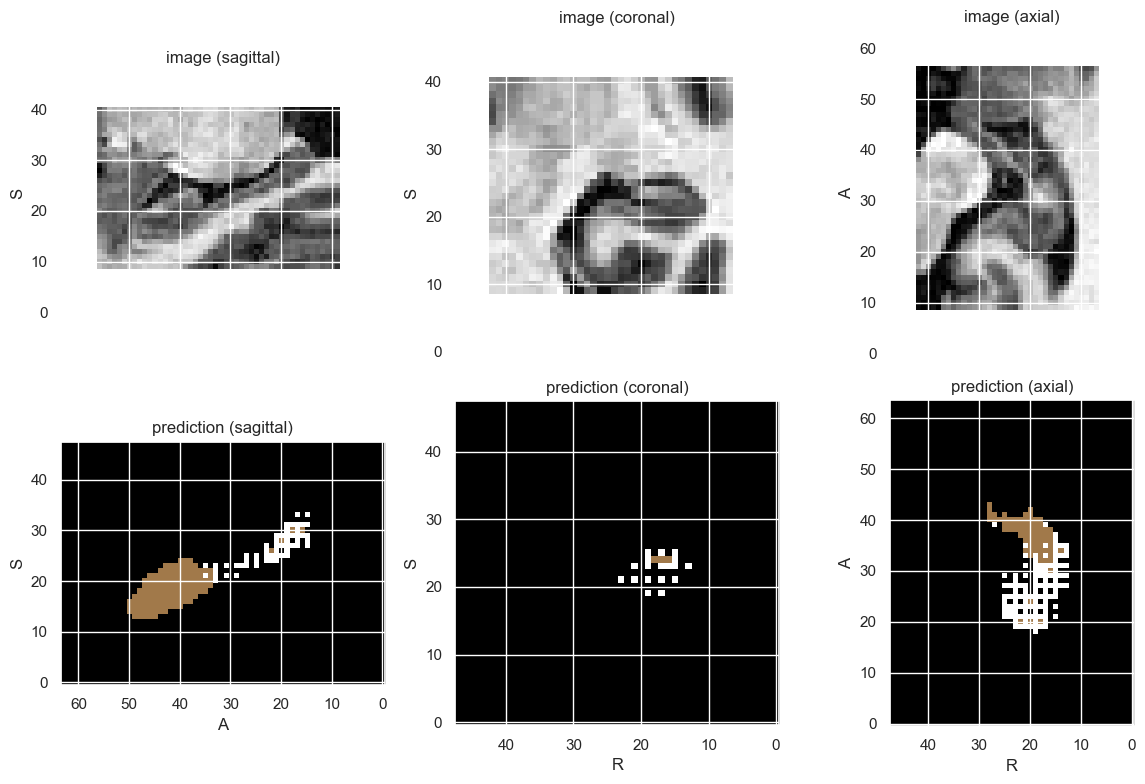

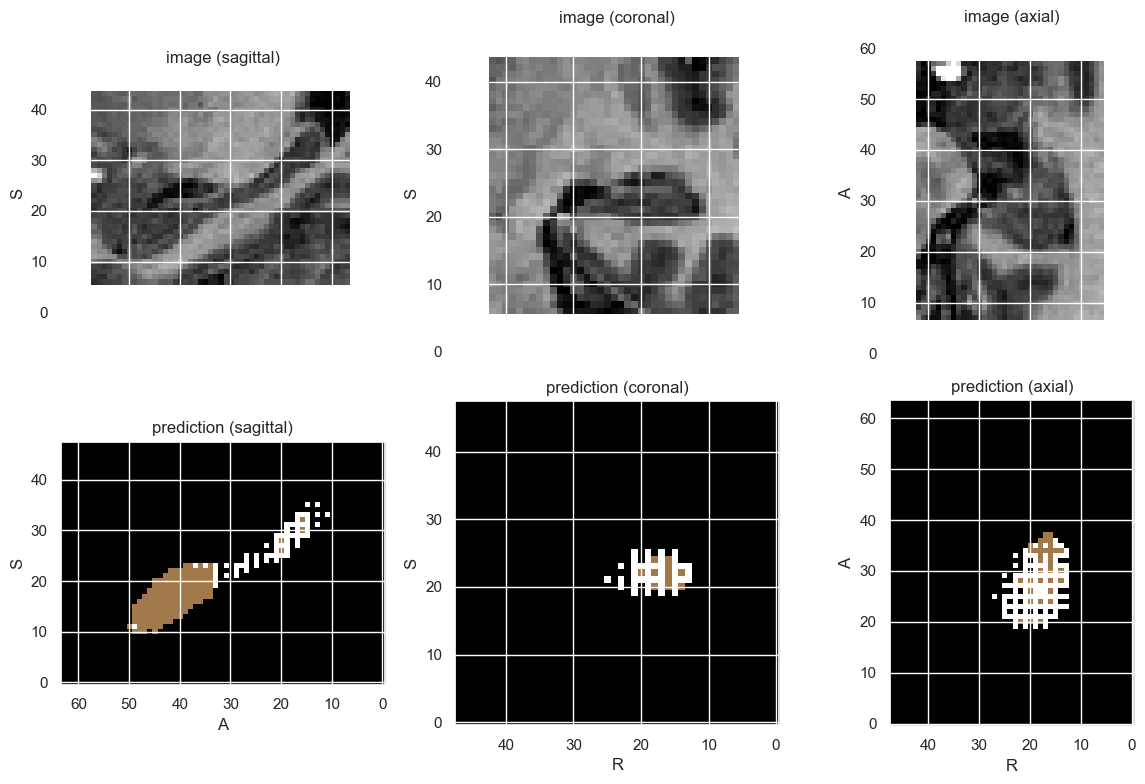

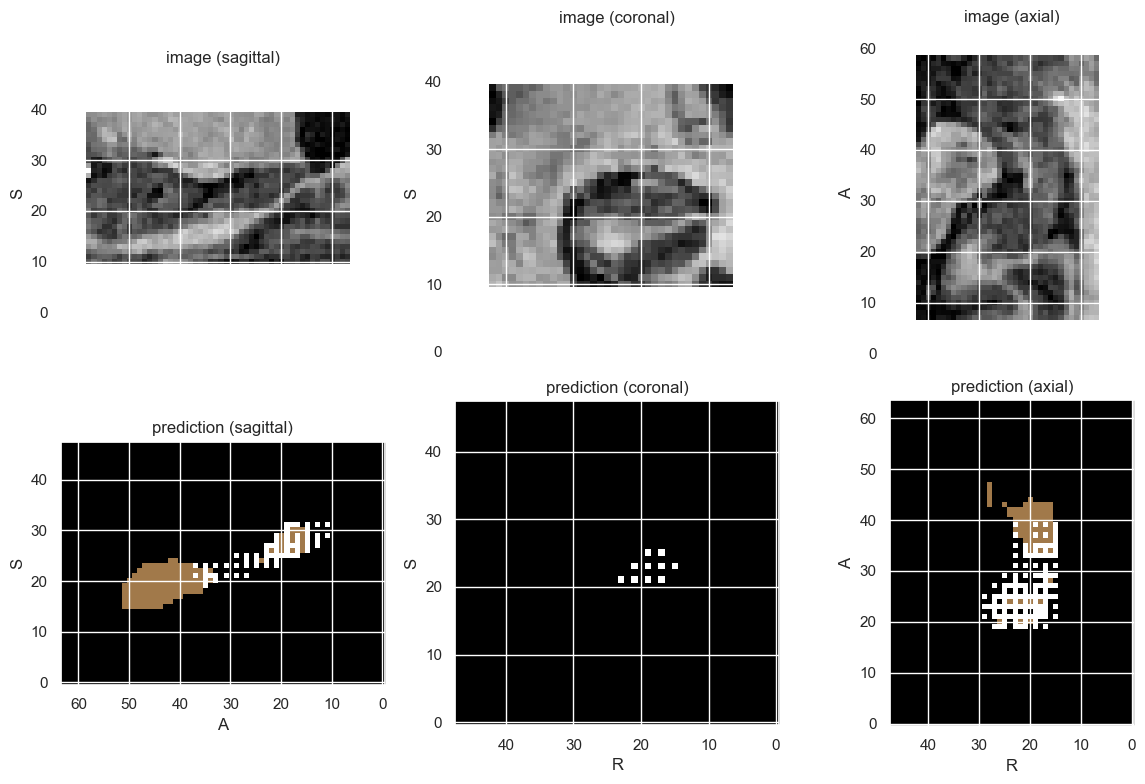

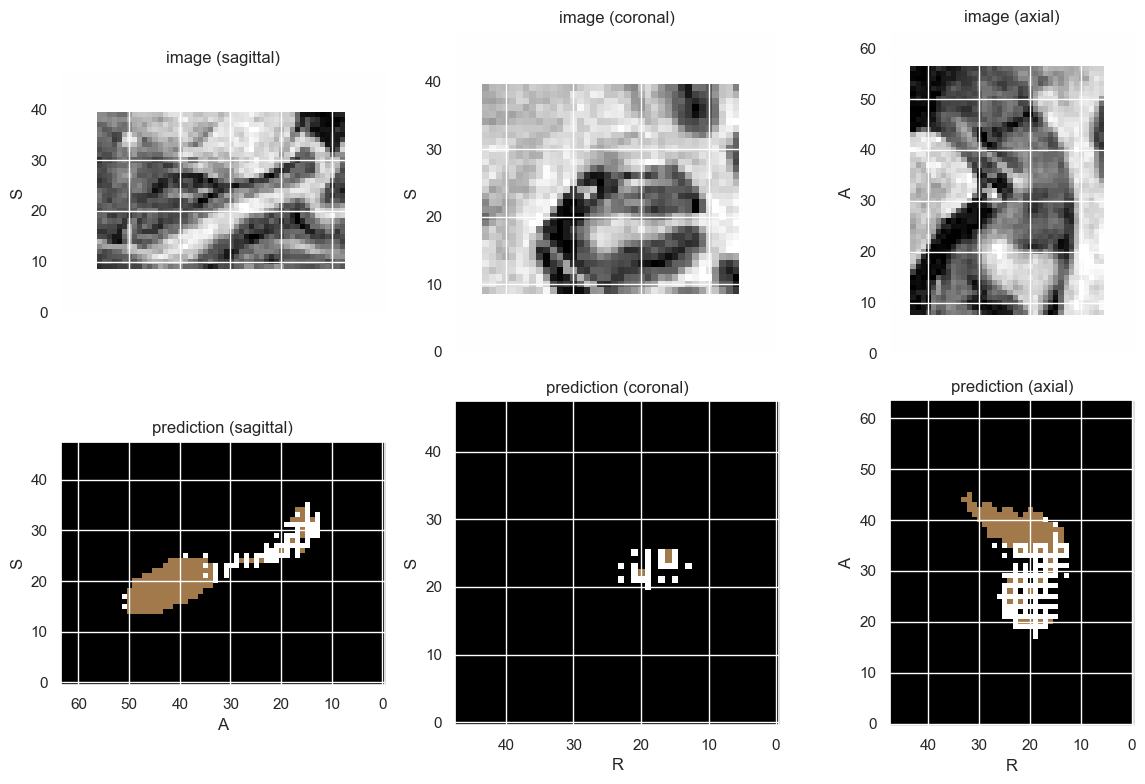

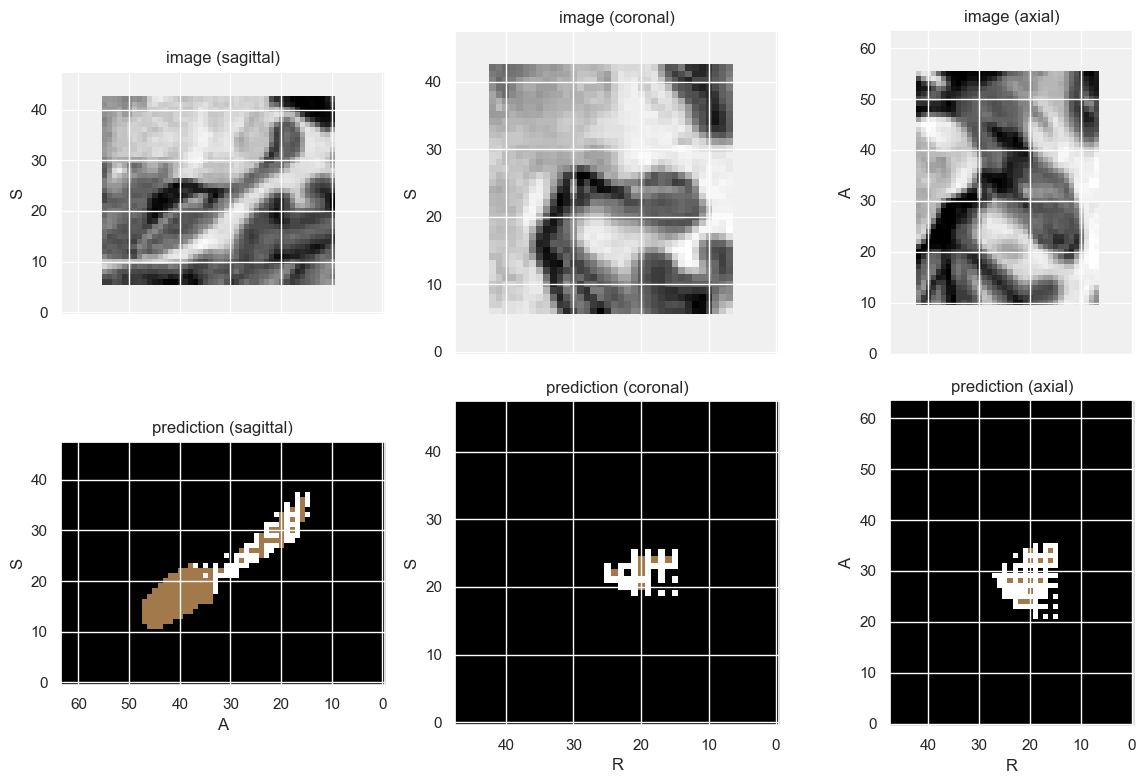

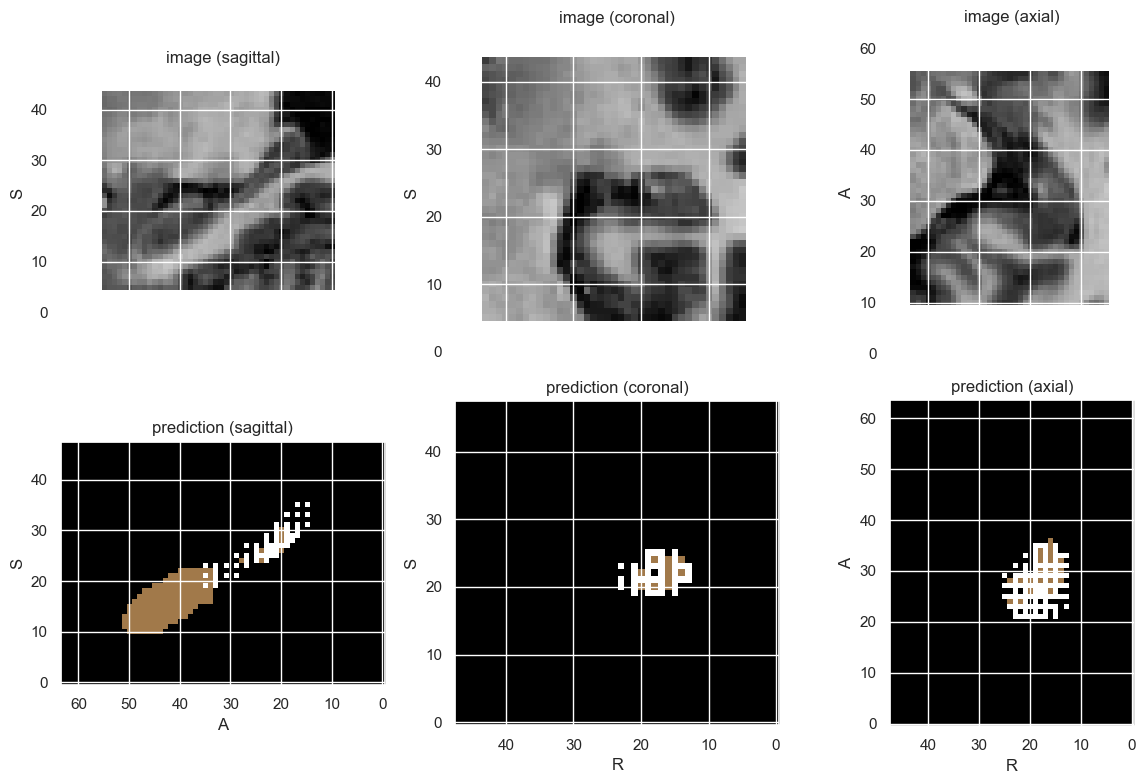

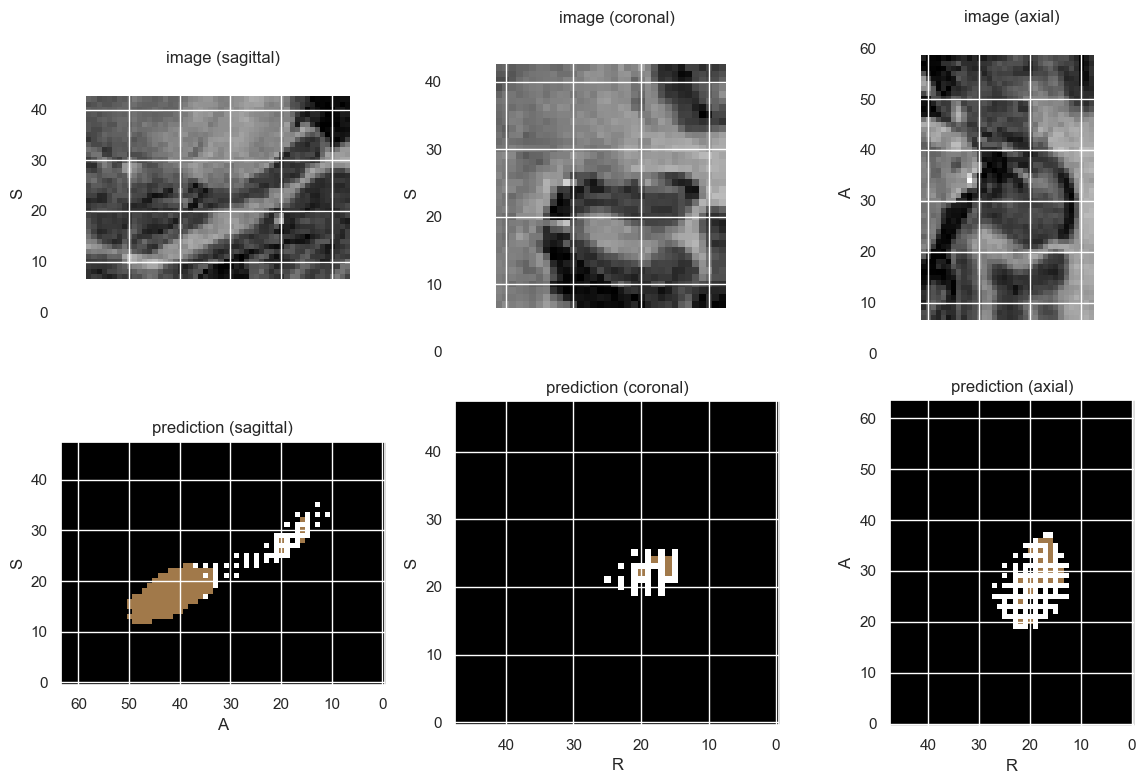

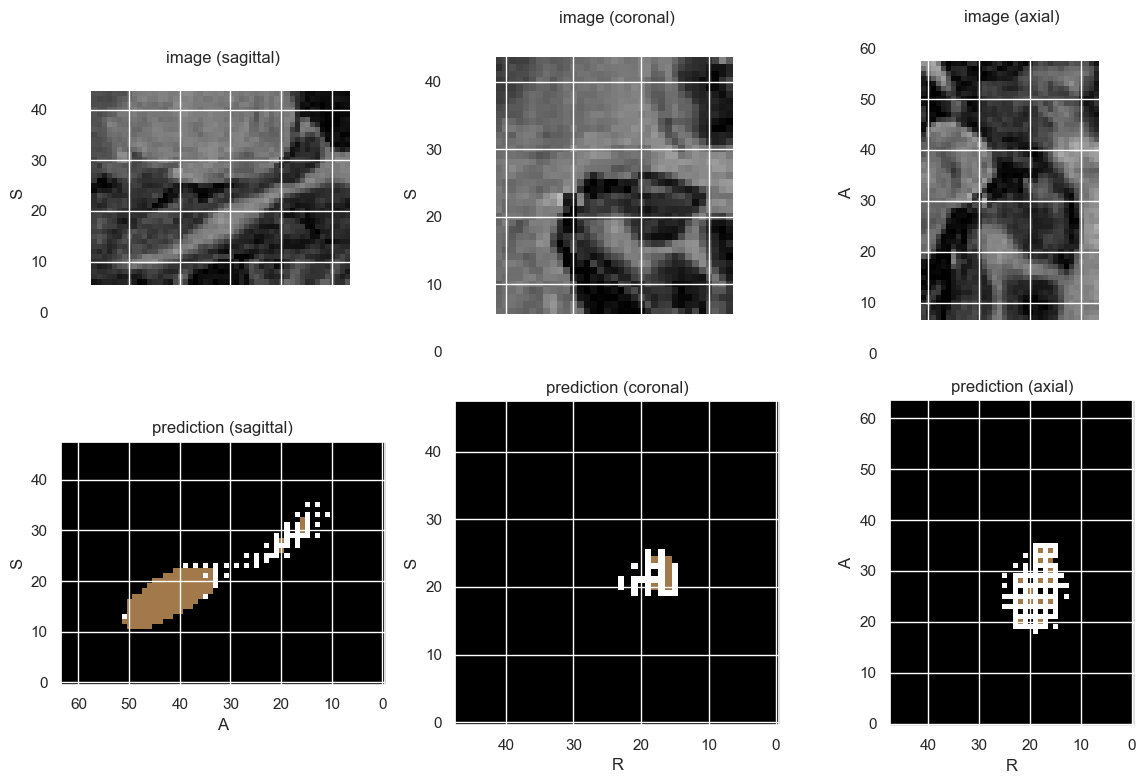

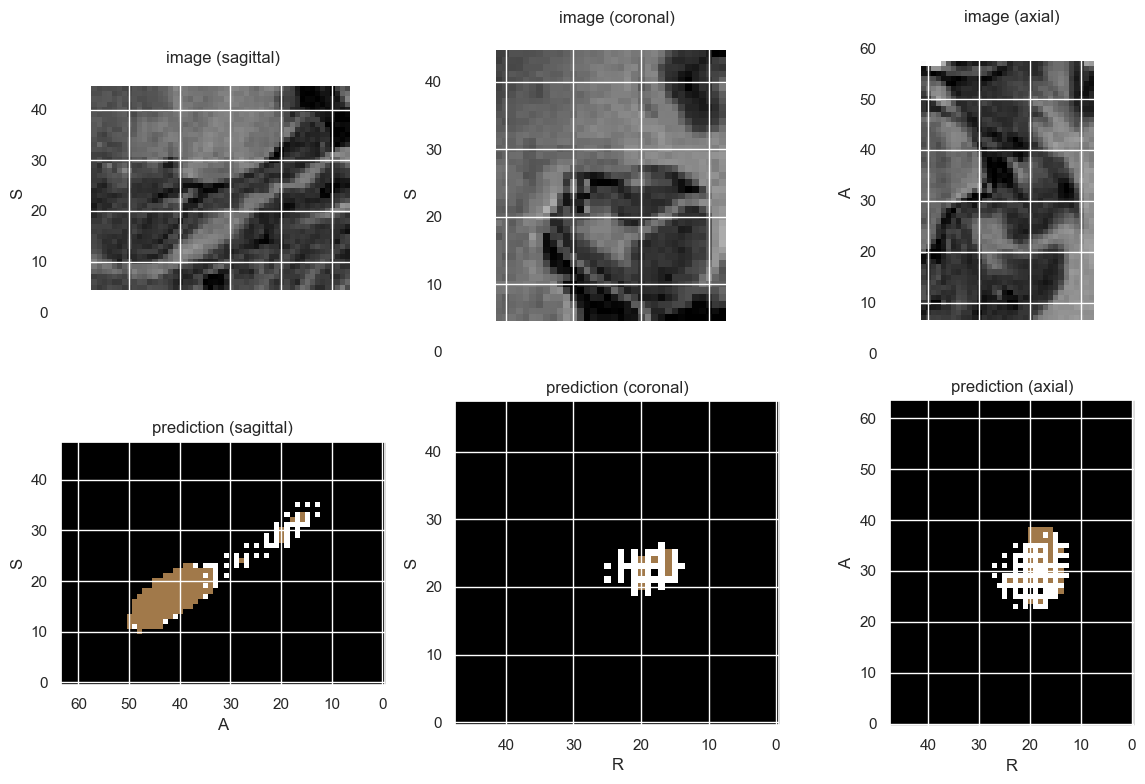

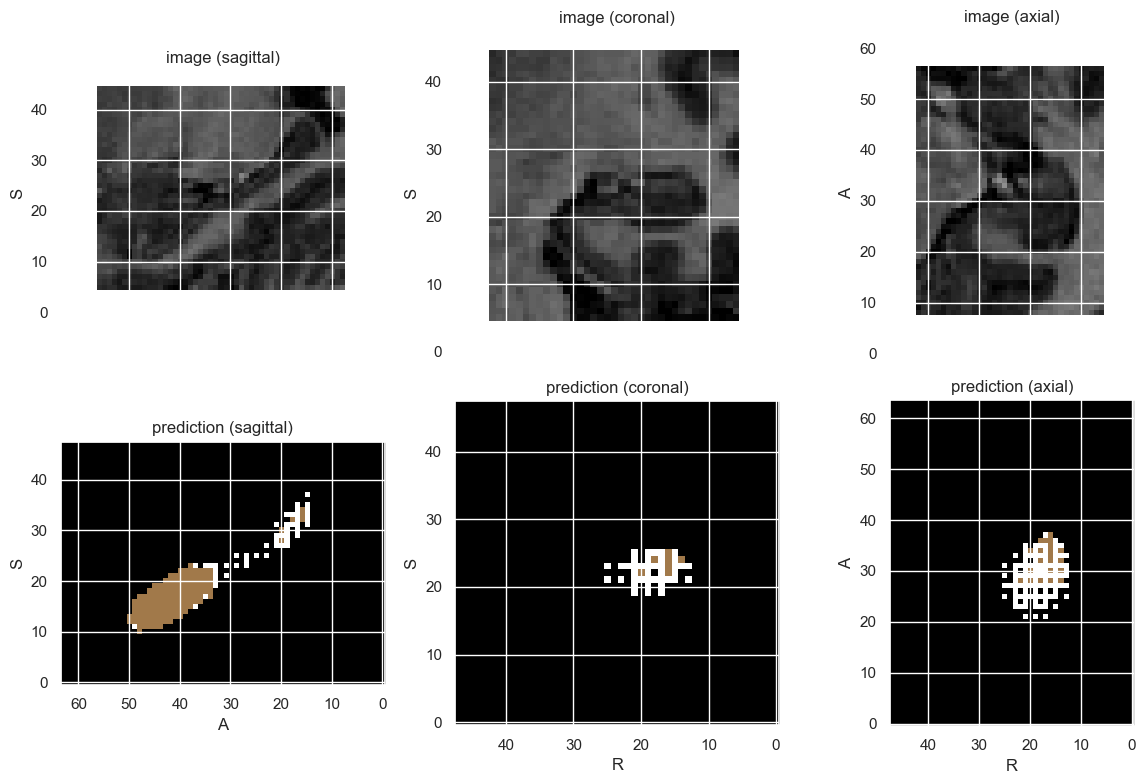

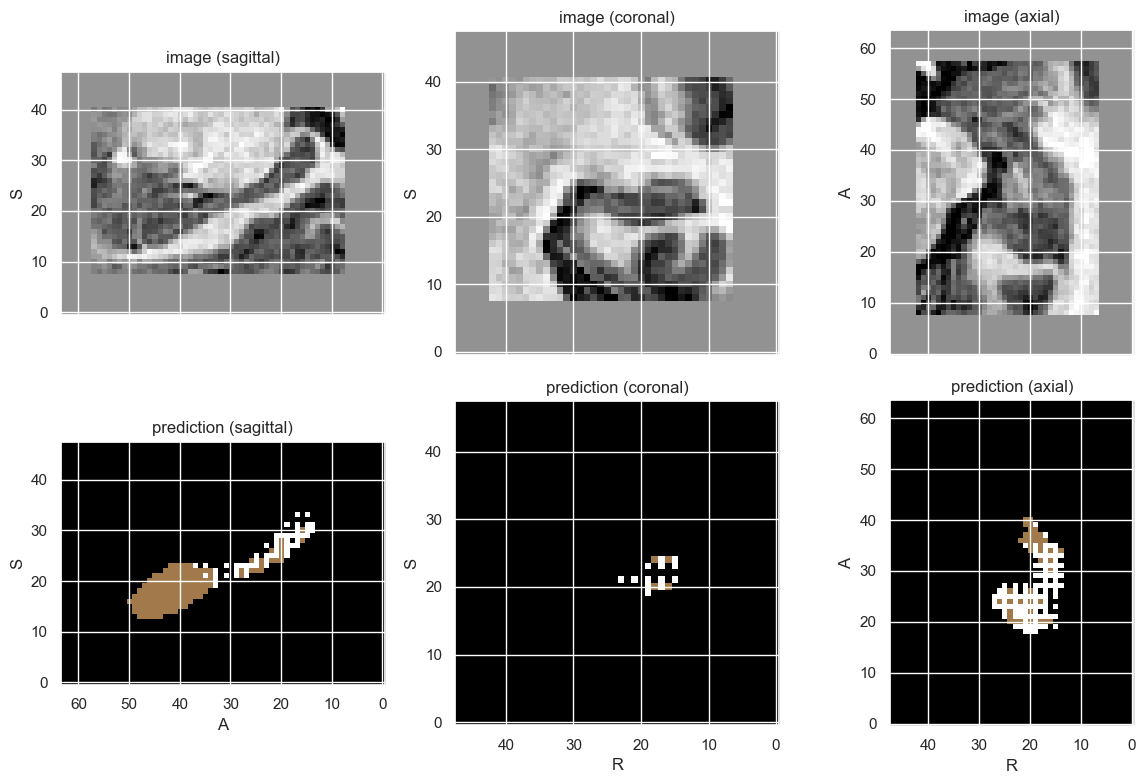

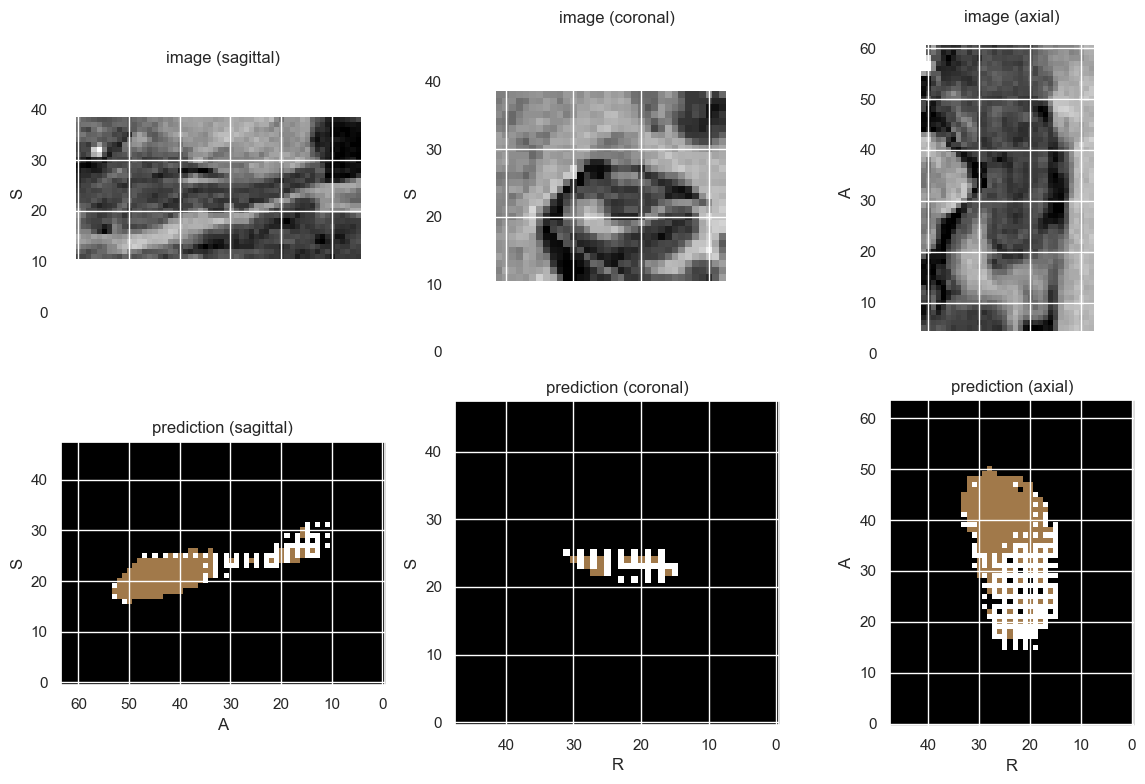

In [22]:
for subject in batch_subjects:
    subject.plot()

The white grids are normally not shown. We can see them because Seaborn modified Matplotlib's settings when we callled `sns.set()`. But they help us make a mental alignment between the MRIs and the segmentation, so we will allow this to happen here.

We cannot plot quantitative results because annotations for the test set are not available. However, we can see that results seem reasonable overall.

## Conclusion

In this tutorial, we used three state-of-the-art open-source libraries of the PyTorch Ecosystem to train a convolutional neural network (CNN) on a publicly available dataset of 3D brain MRIs for hippocampus segmentation.

We used:

1. [TorchIO](https://torchio.readthedocs.io/) to load, save and augment the images, and to store them into several convenient data structures.
2. A convolutional neural network, a loss function and an evaluation metric implemented in [MONAI](https://monai.readthedocs.io/).
3. <del>[PyTorch Lightning](https://www.pytorchlightning.ai/) to automate the training pipeline and avoid writing</del> error-prone boilerplate code.
4. Data-science-related tools such as Google Colab, TensorBoard, Pandas or Matplotlib to run our code and visualize qualitative and quantitative results.

The experiment is fully reproducible as we used very specific versions of all the libraries and set up the random number generators to get deterministic results.

If you have any questions or find some problems, contact me by e-mail.
